## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import warnings; warnings.simplefilter('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
import pickle
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
import json
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\dom\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Features table

In [2]:
data = pd.read_csv('ready_data.csv')

In [3]:
Features = data[['stories', 'fireplace', 'sqft', 'PrivatePool',
                 'Year built', 'Remodeled year', 'baths/bed',
                 'Parking', 'school_rating', 'density', 'status', 'propertyType']]
target = data.Price

In [4]:
Features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214022 entries, 0 to 214021
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   stories         214022 non-null  int64  
 1   fireplace       214022 non-null  int64  
 2   sqft            214022 non-null  float64
 3   PrivatePool     214022 non-null  int64  
 4   Year built      214022 non-null  int64  
 5   Remodeled year  214022 non-null  int64  
 6   baths/bed       214022 non-null  float64
 7   Parking         214022 non-null  int64  
 8   school_rating   214022 non-null  int64  
 9   density         214022 non-null  float64
 10  status          214022 non-null  int64  
 11  propertyType    214022 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 19.6 MB


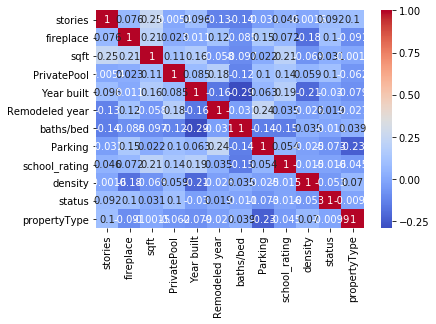

In [5]:
sns.heatmap(Features.corr(), annot=True, cmap='coolwarm')
#most of the variables have low correlation

The most correlated features are Year built with bath/bed and propertyType with Parking but still correlation is small so I'll leave all of the features

# Additional features

In [6]:
scaler = StandardScaler()
FeaturesSt = scaler.fit_transform(Features)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(FeaturesSt, target, random_state=42, test_size=0.2)
print('X_train:', X_train.shape, type(X_train))
print('X_test:', X_test.shape)
print('y_train:', y_train.shape, type(y_train))
print('y_test:', y_test.shape)

X_train: (171217, 12) <class 'numpy.ndarray'>
X_test: (42805, 12)
y_train: (171217,) <class 'pandas.core.series.Series'>
y_test: (42805,)


In [8]:
LR =  LinearRegression()
DTR = DecisionTreeRegressor(max_depth=10, criterion='mae', random_state=42)
RFR = RandomForestRegressor(max_depth=20, random_state=42)
ABR = AdaBoostRegressor(LR, n_estimators=500, learning_rate=0.8)

In [9]:
#Parameters for LR
distributions={
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'n_jobs': [-1, 5, None]
}
LRP = RandomizedSearchCV(LR, distributions, random_state=0)
search = LRP.fit(X_train, y_train)
LRnew =  LinearRegression(**search.best_params_)

In [10]:
#Parameters for DecisionTreeRegressor(DTR)
distributions={
    'max_depth': [3, 7, 9, 17, 30, None],
    'criterion': ['mse', 'friedman_mse'],
    'random_state': [0, 42],
    'min_samples_split': [2, 4, 7],
    'min_samples_leaf': [1, 5],
    'max_features': ['auto', 'sqrt', None]
}
r = RandomizedSearchCV(DTR, distributions, random_state=0)
search = r.fit(X_train, y_train)
DTRnew = DecisionTreeRegressor(**search.best_params_)

In [11]:
#find optimal parameters for Random Forest Regressor with 3 evaluations

def acc_model(params):
    reg = RandomForestRegressor(**params)
    
    return cross_val_score(reg, X_train, y_train).mean()

param_space = {
    'n_estimators': hp.choice('n_estimators', range(1,100)),
    'criterion': 'mse', 
    'max_depth': hp.choice('max_depth', range(1,50)),
    'random_state': hp.choice('random_state', range(0,42))
}

best_rf = 0
def f(params):
    global best_rf
    acc = acc_model(params)
    if acc > best_rf:
        best_rf = acc
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best_rf = fmin(f, param_space, algo=tpe.suggest, max_evals=3, trials=trials)
print ('best_rf_params:')
print (best_rf)

100%|█████████| 3/3 [03:21<00:00, 67.62s/trial, best loss: -0.7627053698378489]
best_rf_params:
{'max_depth': 37, 'n_estimators': 44, 'random_state': 0}


In [12]:
RFRnew = RandomForestRegressor(**best_rf)

In [13]:
#find optimal parameters for AdaBoostRegressor with 5 evaluations
l = ['linear', 'square', 'exponential']
be = [None, LinearRegression()]
def acc_model(params):
    reg = AdaBoostRegressor(**params)
    
    return cross_val_score(reg, X_train, y_train).mean()

param_space = {
    'base_estimator': hp.choice('base_estimator', be),
    'n_estimators': hp.choice('n_estimators', range(1, 100)), 
    'learning_rate': hp.quniform('learning_rate', 0.1, 1, 0.1),
    'loss': hp.choice('loss', l),
    'random_state': hp.choice('random_state', range(1, 50))
}

best_adab = 0
def f(params):
    global best_adab
    acc = acc_model(params)
    if acc > best_adab:
        best_adab = acc
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best_adab = fmin(f, param_space, algo=tpe.suggest, max_evals=5, trials=trials)
print ('best_adaboost_params:')
best_adab['loss'] = l[best_adab['loss']]
best_adab['base_estimator'] = be[best_adab['base_estimator']]
print (best_adab)

100%|█████████| 5/5 [03:19<00:00, 36.98s/trial, best loss: -0.3924000146048443]
best_adaboost_params:
{'base_estimator': None, 'learning_rate': 0.9, 'loss': 'linear', 'n_estimators': 91, 'random_state': 28}


In [14]:
ABRnew = AdaBoostRegressor(**best_adab)

In [15]:
def compute_meta_feature(regr, X_train, X_test, y_train, cv):
    """
    Computes meta-features using the regressor.
    
    :arg regr: scikit-learn regressor
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    X_meta_train = np.zeros_like(y_train, dtype = np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_r = clone(regr)
        folded_r.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_r.predict(X_fold_predict)
    
    meta_r = clone(regr)
    meta_r.fit(X_train, y_train)
    
    X_meta_test = meta_r.predict(X_test)
    
    return X_meta_train, X_meta_test

In [16]:
def generate_metafeatures(regrs, X_train, X_test, y_train, cv):
    """
    Generates metafeatures using a list of regressors.
    
    :arg regrs: list of scikit-learn regressors
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    features = [
        compute_meta_feature(regr, X_train, X_test, y_train, cv)
        for regr in tqdm(regrs)
    ]
    
    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T
    
    return stacked_features_train, stacked_features_test

In [17]:
#additional features using stacking
cv = KFold(n_splits=10, shuffle=True)
stacked_features_train, stacked_features_test = generate_metafeatures([LRnew, DTRnew, RFRnew, ABRnew],X_train, 
                                                                      X_test, y_train.values, cv)

100%|███████████████████████████████████████████| 4/4 [07:38<00:00, 109.99s/it]


In [18]:
total_features_train = np.hstack([X_train, stacked_features_train])
total_features_test = np.hstack([X_test, stacked_features_test])

In [19]:
with open('train_data.npy', 'wb') as f:
    np.save(f, total_features_train)
    np.save(f, y_train)
    np.save(f, total_features_test)
    np.save(f, y_test)

In [20]:
import numpy as np
with open('train_data.npy', 'rb') as f:
    total_features_test = np.load(f)

In [21]:
random_value = np.random.choice(len(total_features_test))
columns = Features.columns.values.tolist()
columns.extend(['lr', 'dtr', 'rfr', 'abr'])
dft = pd.DataFrame(total_features_test[random_value].reshape(1,16), columns=columns)

In [22]:
dft.to_json(r'test_example.json',orient='records')

## Data visualization

Text(0.5, 0, 'Relative Importance')

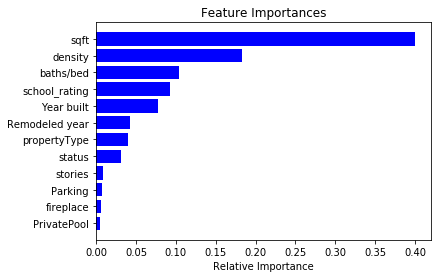

In [25]:
features=Features.columns[[0,1,2,3,4,5,6,7,8,9,10,11]]
DTRnew.fit(Features, target)
importances = DTRnew.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

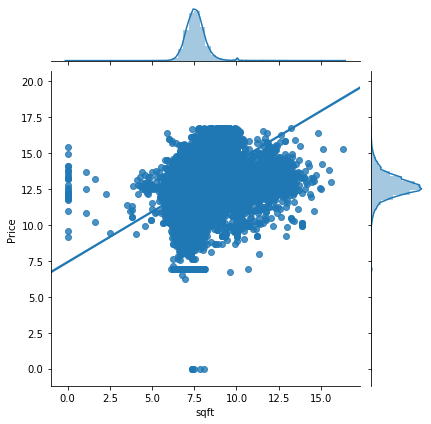

In [26]:
sns.jointplot(x = 'sqft', y = 'Price', data = data, kind = 'reg')

According to regression line the Price grows with property area size

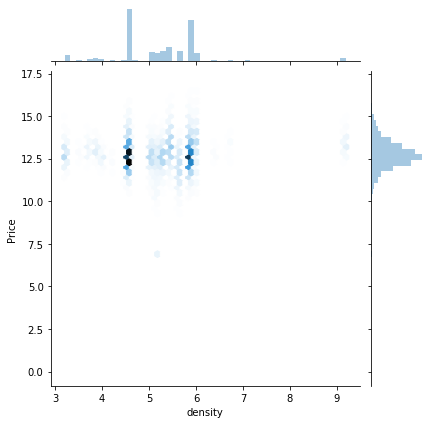

In [27]:
sns.jointplot(x = 'density', y = 'Price', data = data, kind = 'hex')

might be two or tree clusters

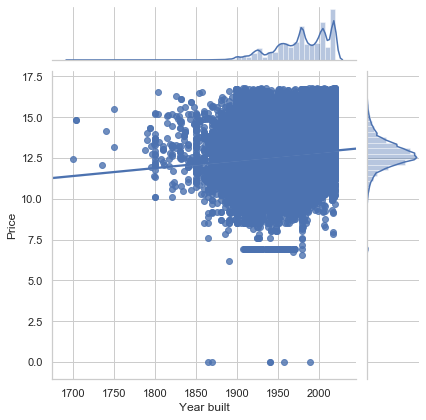

In [31]:
sns.jointplot(x = 'Year built', y = 'Price', data = data, kind = 'reg')

According to regression line the Price grows with Year build

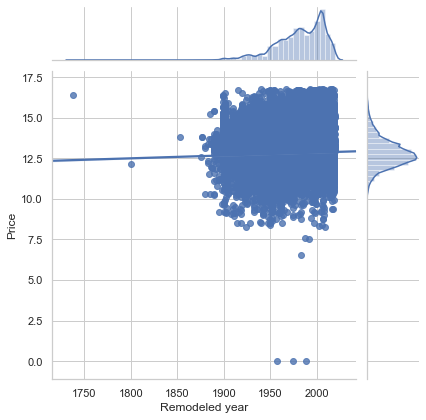

In [32]:
sns.jointplot(x = 'Remodeled year', y = 'Price', data = data[data['Remodeled year']>0], kind = 'reg')

The price grows a little with remodeled year

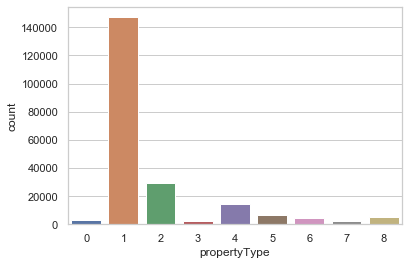

In [33]:
sns.countplot(x = 'propertyType', data=data)

Most of the data is of property type "Single family"

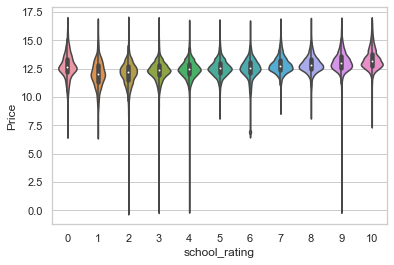

In [38]:
sns.set(style = 'whitegrid')  
      
sns.violinplot(x = 'school_rating', y = 'Price', data=data) 

The price slightly grows with school rating

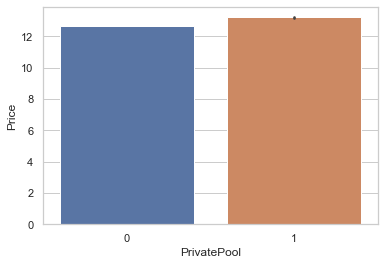

In [35]:
sns.barplot(x = 'PrivatePool',y = 'Price', data = data)

The price for property with pool is a liitle bit higher

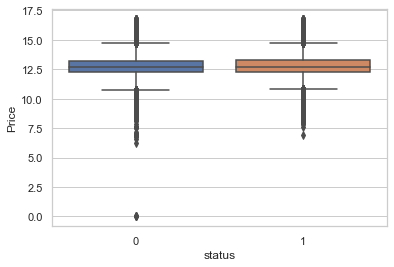

In [36]:
sns.boxplot(x = 'status', y = 'Price', data=data)

Status feature doesn't influence Price

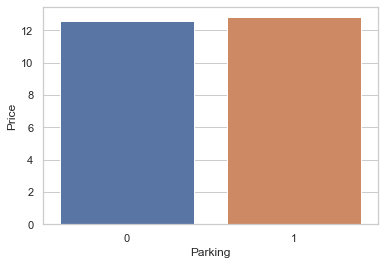

In [37]:
sns.barplot(x = 'Parking',y = 'Price', data = data)

Parking seems not to influence price